## GOES Irradiance Corrections
[X]     First, convert x and y values to latitude and longitude

[ ]     Then, downscale Channel 05 (1km res.) and 13 (2km res.) to the Channel 02 (0.5km res.) grid using linear interpolation.

[ ]     Next, combine all bands to one dataset

[ ]     To clip each band appropriately, we need to convert raw radiance values to reflectivity (channels 2 and 5) and brightness temperature (channel 13). Loosely based off of Brian Blaylock's goes2go

[ ]     Now we can save our new, corrected RGB dataset as one zarr file for each day



In [1]:
from goes2go.rgb import normalize as goes_norm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

/home/cdalden/miniforge3/envs/goes_old/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/tmp/ipykernel_22490/1917207869.py:1: DeprecationWarning: The rgb module is deprecated. Use the rgb accessor instead. See https://goes2go.readthedocs.io/en/latest/user_guide/notebooks/DEMO_rgb_recipes.html for examples.
  from goes2go.rgb import normalize as goes_norm


In [2]:
# Calculate latitude and longitude from GOES ABI fixed grid projection data
# GOES ABI fixed grid projection is a map projection relative to the GOES satellite
# Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
# See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculations
# "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library

# Clinton's note: needed to change how attributes of the goes imager projection were accessed

def calculate_degrees(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.attrs['longitude_of_projection_origin']
    H = projection_info.attrs['perspective_point_height']+projection_info.attrs['semi_major_axis']
    r_eq = projection_info.attrs['semi_major_axis']
    r_pol = projection_info.attrs['semi_minor_axis']
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

In [83]:
def downscale_goes_bands(date):

    # Load the GOES-16 ABI data
    path = '/storage/cdalden/goes/goes16/'
    file = f'goes16_C02_colorado_{date}.zarr'
    ds_C02 = xr.open_dataset(path+'channel02/'+file)
    file = f'goes16_C05_colorado_{date}.zarr'
    ds_C05 = xr.open_dataset(path+'channel05/'+file)
    file = f'goes16_C13_colorado_{date}.zarr'
    ds_C13 = xr.open_dataset(path+'channel13/'+file)

    # convert to lat and lon from x and y coordinates
    lat_C02, lon_C02 = calculate_degrees(ds_C02)
    lat_C05, lon_C05 = calculate_degrees(ds_C05)
    lat_C13, lon_C13 = calculate_degrees(ds_C13)
    ds_C02 = ds_C02.assign_coords(y=("y", lat_C02[:,0]), x=("x", lon_C02[0,:]))
    ds_C05 = ds_C05.assign_coords(y=("y", lat_C05[:,0]), x=("x", lon_C05[0,:]))
    ds_C13 = ds_C13.assign_coords(y=("y", lat_C13[:,0]), x=("x", lon_C13[0,:]))

    # Extract time coordinates from ds_C02
    time_C02 = ds_C02['t']
    ds_C13 = ds_C13.assign_coords(t=time_C02)
    ds_C05 = ds_C05.assign_coords(t=time_C02)

    # Ensure the coordinate ranges overlap
    target_lat = ds_C02['y']
    target_lon = ds_C02['x']

    # Align the coordinates of ds_C13 with ds_C02
    ds_C13_aligned = ds_C13.reindex_like(ds_C02, method='nearest')
    ds_C05_aligned = ds_C05.reindex_like(ds_C02, method='nearest')

    # Interpolate the source dataset to the target dataset's grid using a specified method
    ds_C13_resampled = ds_C13_aligned.interp(y=target_lat, x=target_lon, method='linear')
    ds_C05_resampled = ds_C05_aligned.interp(y=target_lat, x=target_lon, method='linear')
    # If there are still NaNs, try filling them with a method like nearest neighbor
    ds_C13_resampled_filled = ds_C13_resampled.fillna(ds_C13_aligned.interp(y=target_lat, x=target_lon, method='nearest'))
    ds_C05_resampled_filled = ds_C05_resampled.fillna(ds_C05_aligned.interp(y=target_lat, x=target_lon, method='nearest'))

    # Create a new dataset with the two Rad variables
    combined_ds = xr.Dataset(
        {'Rad_C13': ds_C13_resampled_filled['Rad'], 'Rad_C02': ds_C02['Rad'], 'Rad_C05': ds_C05_resampled_filled['Rad']},
        coords={'y': target_lat, 'x': target_lon, 't': ds_C02['t']})
    
    return combined_ds

def goes_clip_normalize(ds):

    ds['green'] = goes_norm(ds['Rad_C02'], 0, 0.78, clip=True)
    ds['blue'] = goes_norm(ds['Rad_C05'], 0.01, 0.59, clip=True)
    ds['red'] = goes_norm(ds['Rad_C13'], -53.5, 7.5, clip=True)

    return ds
    

In [81]:
ds = downscale_goes_bands('20230605')

In [84]:
final_ds = goes_clip_normalize(ds)

In [85]:
final_ds

<xarray.Dataset> Size: 9GB
Dimensions:  (t: 288, y: 640, x: 966)
Coordinates:
  * t        (t) datetime64[ns] 2kB 2023-06-05T00:02:36.606086016 ... 2023-06...
    x_image  float32 4B -0.03136
    y_image  float32 4B 0.08624
  * y        (y) float64 5kB 41.53 41.52 41.51 41.51 ... 37.03 37.02 37.01 37.01
  * x        (x) float64 8kB -112.1 -112.1 -112.1 ... -104.0 -104.0 -104.0
Data variables:
    Rad_C13  (t, y, x) float64 1GB 92.19 92.19 92.19 92.19 ... 89.63 89.63 89.63
    Rad_C02  (t, y, x) float64 1GB 31.73 29.67 33.0 36.49 ... 39.34 38.87 35.85
    Rad_C05  (t, y, x) float64 1GB 7.862 7.862 7.862 9.394 ... 7.383 7.383 7.383
    green    (t, y, x) float64 1GB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    blue     (t, y, x) float64 1GB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    red      (t, y, x) float64 1GB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

In [30]:
# path = '/storage/cdalden/goes/goes16/2023/2/2/ABI-L1b-RadC/00/C13/'
path = '/storage/cdalden/goes/goes16/channel13/'
# file = 'OR_ABI-L1b-RadC-M6C13_G16_s20230330056175_e20230330058559_c20230330059023.nc'
file = 'goes16_C13_colorado_20230602.zarr'
ds_C13 = xr.open_dataset(path+file)

path = '/storage/cdalden/goes/goes16/channel02/'
file = 'goes16_C02_colorado_20230602.zarr'
ds_C02 = xr.open_dataset(path+file)


In [33]:
lat_C13, lon_C13 = calculate_degrees(ds_C13)
lat_C02, lon_C02 = calculate_degrees(ds_C02)

In [75]:
# Assuming lat is your latitude array
lat_C13_diff = np.diff(lat_C13[:,0])
ds_C13 = ds_C13.assign_coords(y=("y", lat_C13[:,0]), x=("x", lon_C13[0,:]))


In [76]:
# Assuming lat is your latitude array
lat_C02_diff = np.diff(lat_C02[:,0])
ds_C02 = ds_C02.assign_coords(y=("y", lat_C02[:,0]), x=("x", lon_C02[0,:]))


In [72]:
# Extract time coordinates from ds_C02
time_C02 = ds_C02['t']

# Assign the time coordinates of ds_C02 to ds_C13
ds_C13 = ds_C13.assign_coords(t=time_C02)

# Ensure the coordinate ranges overlap
target_lat = ds_C02['y']
target_lon = ds_C02['x']

# Align the coordinates of ds_C13 with ds_C02
ds_C13_aligned = ds_C13.reindex_like(ds_C02, method='nearest')

# Interpolate the source dataset to the target dataset's grid using a specified method
ds_C13_resampled = ds_C13_aligned.interp(y=target_lat, x=target_lon, method='linear')

# Check for NaNs in the resampled data
print("Number of NaNs in ds_C13_resampled['Rad']:", ds_C13_resampled['Rad'].isnull().sum().values)

# If there are still NaNs, try filling them with a method like nearest neighbor
ds_C13_resampled_filled = ds_C13_resampled.fillna(ds_C13_aligned.interp(y=target_lat, x=target_lon, method='nearest'))

# Check for NaNs in the filled resampled data
print("Number of NaNs in ds_C13_resampled_filled['Rad']:", ds_C13_resampled_filled['Rad'].isnull().sum().values)

ds_C13 lat range: 37.015226702875935 41.5159331541639
ds_C13 lon range: -112.08602443252897 -104.0141981175058
ds_C02 lat range: 37.006368133142395 41.52884252588635
ds_C02 lon range: -112.11779556724674 -104.00076614744458
Number of NaNs in ds_C13_resampled['Rad']: 0
Number of NaNs in ds_C13_resampled_filled['Rad']: 0


In [16]:
# Dictionary to store datasets
datasets = {}

for channel in ['02', '05', '13']:
    ds = goes_clip_normalize(channel, '20230610')
    datasets[f'ds_C{channel}'] = ds
    print(f"Channel {channel} normalized.")

# Access datasets using the channel name
ds_C02 = datasets['ds_C02']
ds_C05 = datasets['ds_C05']
ds_C13 = datasets['ds_C13']


# Combine the normalized variables into a new dataset
# ds_RGB = xr.Dataset({
#     'red': ds_C13['red'],
#     'green': ds_C02['green'],
#     'blue': ds_C05['blue']
# })

# ds_RGB

Channel 02 normalized.
Channel 05 normalized.
Channel 13 normalized.


NameError: name 'ds_RGB' is not defined

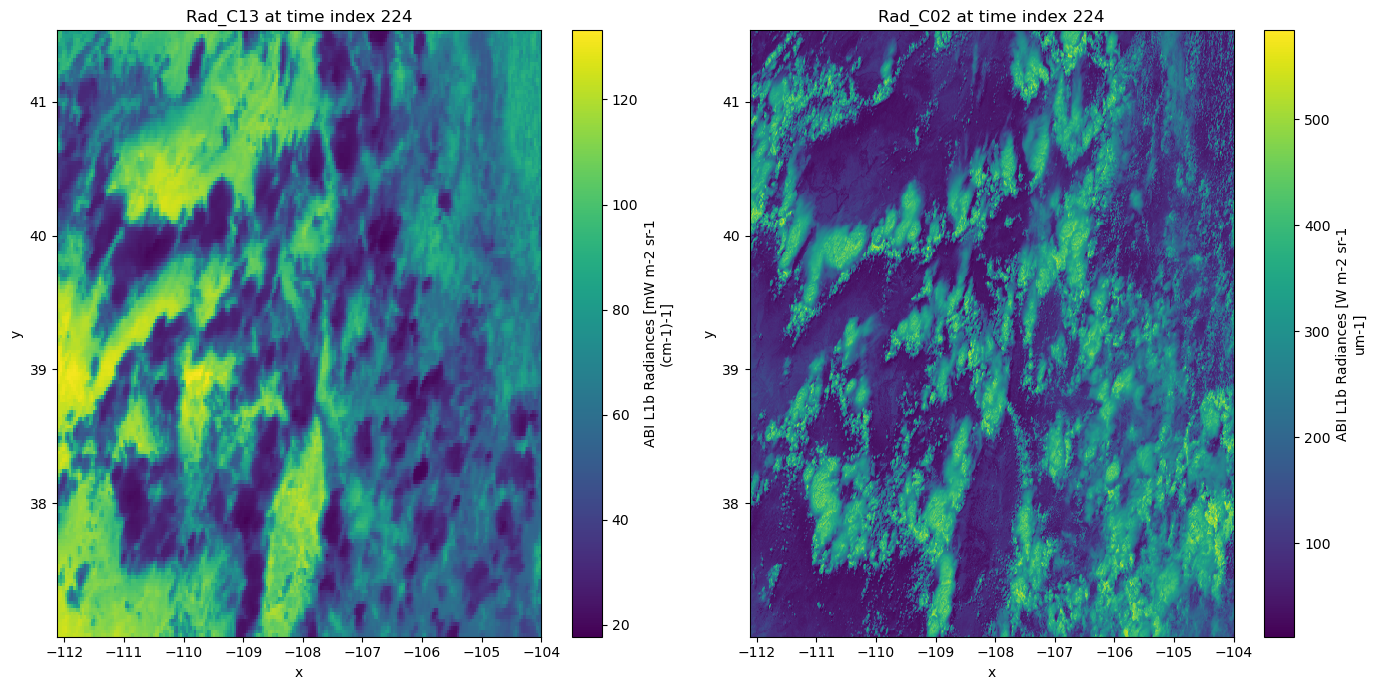

In [87]:
# Select a random time index
random_time_index = np.random.randint(0, len(ds['t']))

# Extract the data for the random time
rad_C13_data = ds['Rad_C13'].isel(t=random_time_index)
rad_C02_data = ds['Rad_C02'].isel(t=random_time_index)

# Plot the data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Plot Rad_C13
rad_C13_data.plot(ax=axes[0], cmap='viridis')
axes[0].set_title(f'Rad_C13 at time index {random_time_index}')

# Plot Rad_C02
rad_C02_data.plot(ax=axes[1], cmap='viridis')
axes[1].set_title(f'Rad_C02 at time index {random_time_index}')

plt.tight_layout()
plt.show()